# Image Enhancement: Deblurring and Denoising



In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from numpy import fft
from utils.utils import psf_fft, A, AT, gaussian_kernel

In [3]:
# load an image
X = data.astronaut()[:, :, 0]

# normalize the image to have values between 0 and 1
X = X / 255.

m, n = X.shape

## Blurring the image

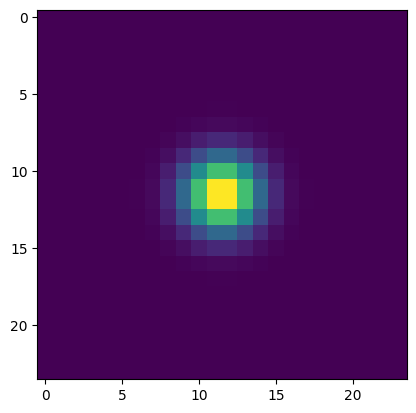

In [4]:
# generate blur filter
k = gaussian_kernel(24, 3) # function from utils
plt.imshow(k)
plt.show()

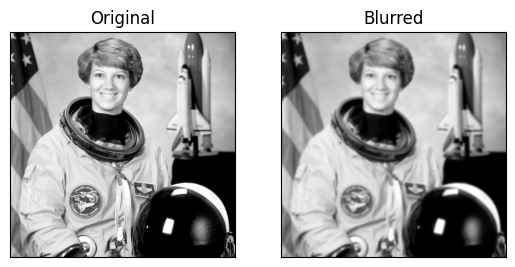

In [5]:
# apply blur with openCV
X_blurred = cv.filter2D(X, -1, k)

# visualization of the result
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

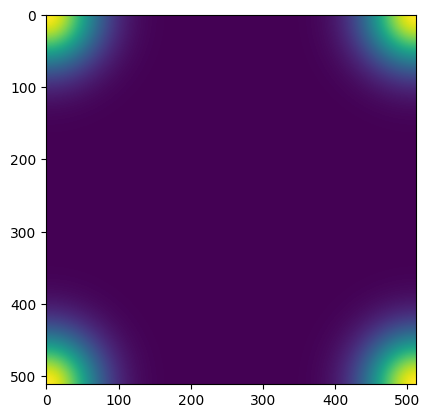

In [6]:
# apply blur with FFT
K = psf_fft(k, 24, X.shape) # function from utils
plt.imshow(np.abs(K))
plt.show()

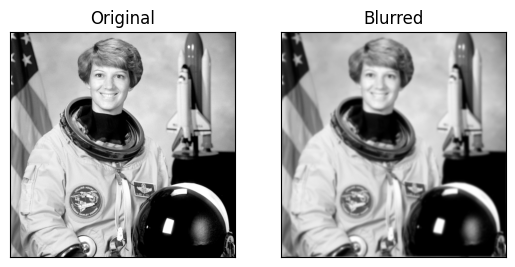

In [7]:
# visualization of the result
X_blurred = A(X, K)
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

## Adding noise

In [8]:
# generate Gaussian white noise
sigma = 0.02
np.random.seed(42)
noise = np.random.normal(0, sigma, size=X.shape)

# add noise to the blurred image
y = X_blurred + noise

# compute metrics to evaluate the quality of the corrupted image
PSNR = metrics.peak_signal_noise_ratio(X, y)
MSE = metrics.mean_squared_error(X, y)

print("PSNR: ", PSNR)
print("MSE: ", MSE)

PSNR:  24.566594758433883
MSE:  0.003494141788106571


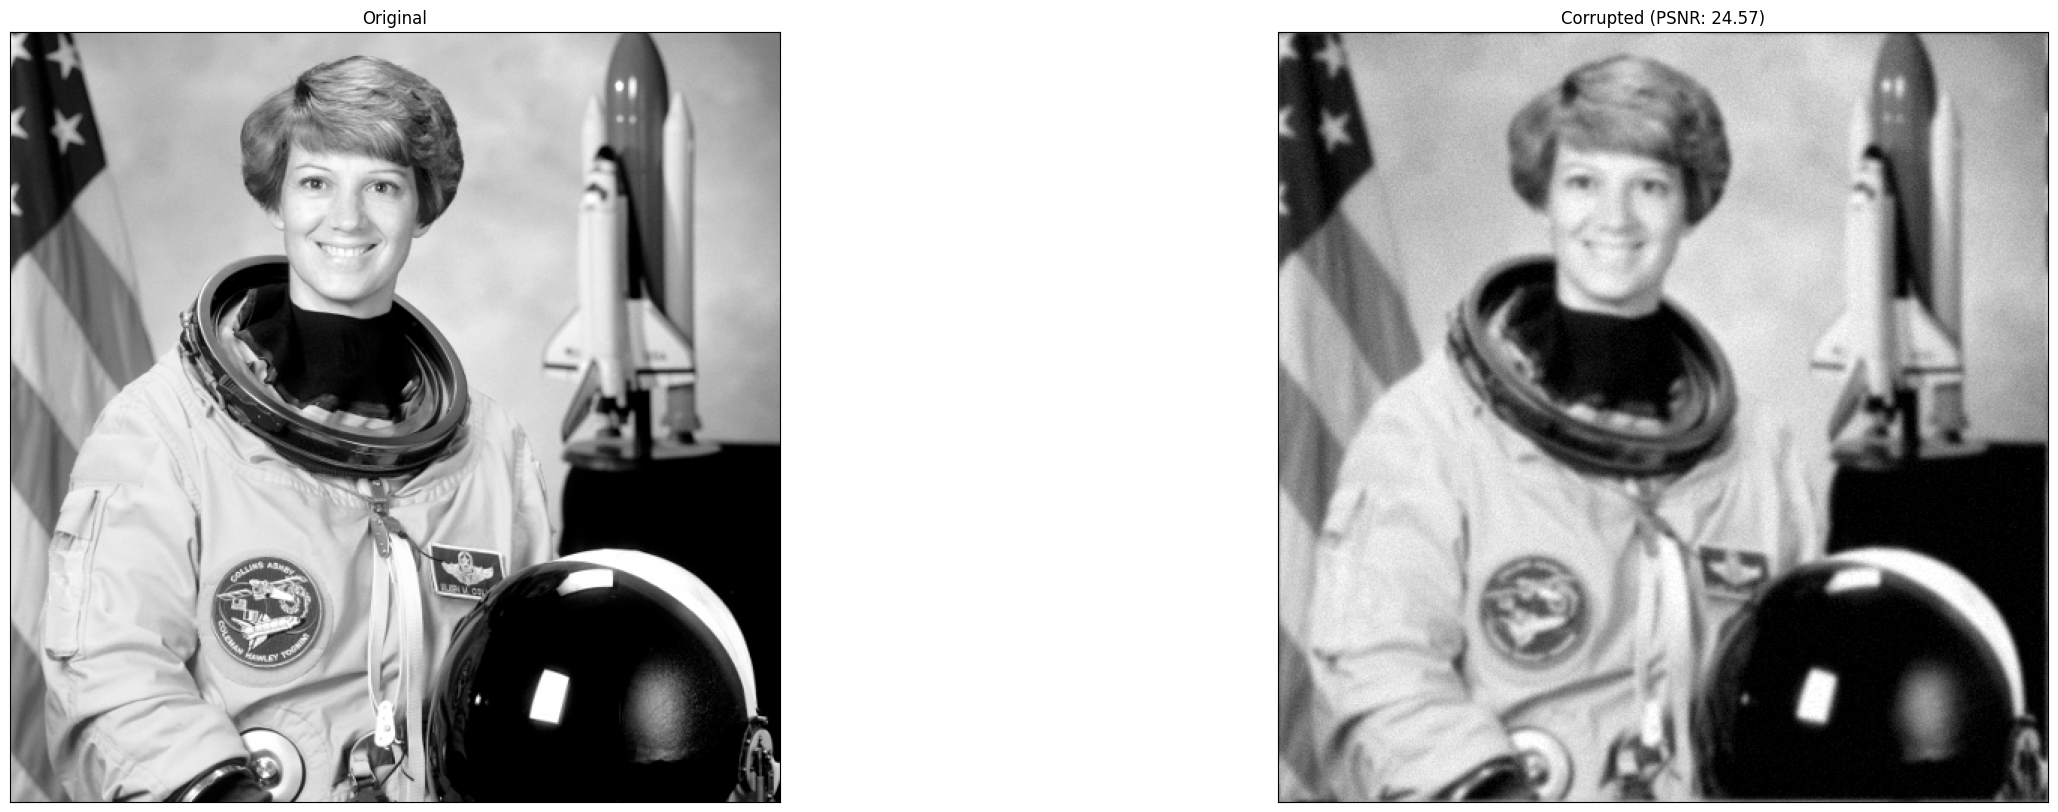

In [9]:
# visualization of the result
plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

## Naive solution to the inverse problem

The naive solution consists of solving the following minimization problem:

$x* =$ $\arg \min_{x}$$\frac{1}{2}$$\left \| Ax - y \right \|$$_2^2$

In [10]:
from scipy.optimize import minimize

In [11]:
ATy = AT(y, K)

# function to minimize
def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))

# gradient of the function to minimize
def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n)

In [12]:
# minimization of the function
x0 = y.reshape(m*n)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter, 'return_all':True})

In [13]:
# for each iteration, calculate PSNR and MSE
PSNRs = np.zeros(max_iter + 1)
MSEs = np.zeros(max_iter + 1)
for k, x_k in enumerate(res.allvecs):
  PSNR = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))
  MSE = metrics.mean_squared_error(X, x_k.reshape(X.shape))
  PSNRs[k] = PSNR
  MSEs[k] = MSE
  print(f'PSNR: {PSNR:.2f}\t MSE: {MSE:.4f}')

# result of minimization
X_res = res.x.reshape((m, n))

PSNR: 24.57	 MSE: 0.0035
PSNR: 25.94	 MSE: 0.0025
PSNR: 26.49	 MSE: 0.0022
PSNR: 26.74	 MSE: 0.0021
PSNR: 26.80	 MSE: 0.0021
PSNR: 26.73	 MSE: 0.0021
PSNR: 26.54	 MSE: 0.0022
PSNR: 26.24	 MSE: 0.0024
PSNR: 25.85	 MSE: 0.0026
PSNR: 25.42	 MSE: 0.0029
PSNR: 24.94	 MSE: 0.0032
PSNR: 24.46	 MSE: 0.0036
PSNR: 23.95	 MSE: 0.0040
PSNR: 23.45	 MSE: 0.0045
PSNR: 22.95	 MSE: 0.0051
PSNR: 22.44	 MSE: 0.0057
PSNR: 21.95	 MSE: 0.0064
PSNR: 21.49	 MSE: 0.0071
PSNR: 21.04	 MSE: 0.0079
PSNR: 20.62	 MSE: 0.0087
PSNR: 20.22	 MSE: 0.0095
PSNR: 19.83	 MSE: 0.0104
PSNR: 19.45	 MSE: 0.0114
PSNR: 19.08	 MSE: 0.0124
PSNR: 18.73	 MSE: 0.0134
PSNR: 18.38	 MSE: 0.0145


In [14]:
# PSNR and MSE of the corrupted image (used for plottin below)
starting_PSNR = np.full(PSNRs.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_MSE = np.full(MSEs.shape[0], metrics.mean_squared_error(X, y))

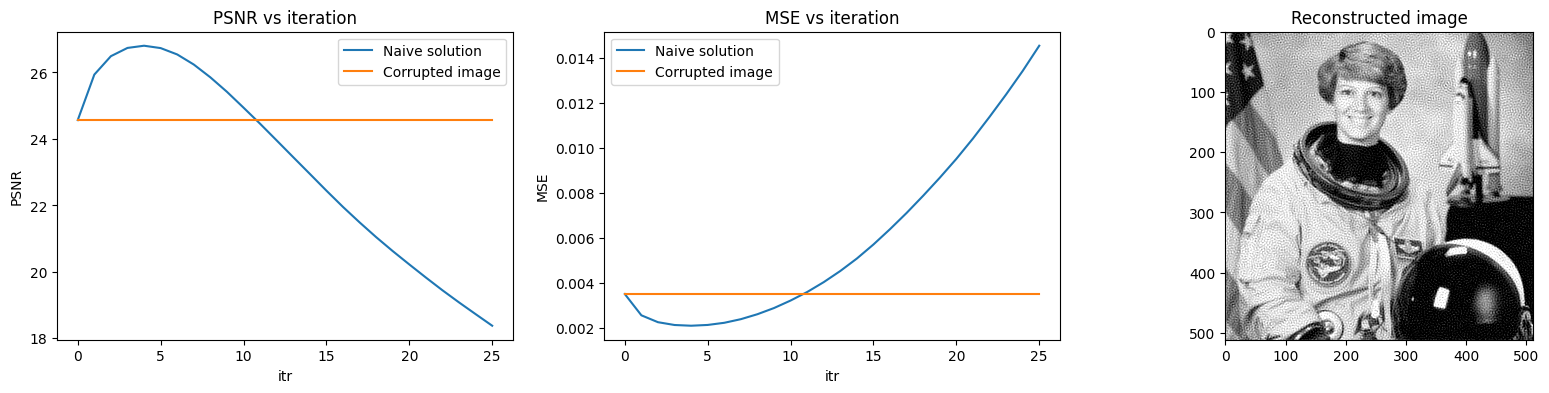

In [15]:
# visualization of the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot(PSNRs, label="Naive solution")
ax1.plot(starting_PSNR, label="Corrupted image")
ax1.legend()
ax1.set_title('PSNR vs iteration')
ax1.set_ylabel("PSNR")
ax1.set_xlabel('itr')

ax2.plot(MSEs, label="Naive solution")
ax2.plot(starting_MSE, label="Corrupted image")
ax2.legend()
ax2.set_title('MSE vs iteration')
ax2.set_ylabel("MSE")
ax2.set_xlabel('itr')

ax3.imshow(X_res, cmap='gray', vmin=0, vmax=1)
ax3.set_title('Reconstructed image')

plt.show()

## Regularized solution

The regularized solution consists of solving the following minimization problem:

$x* =$ $\arg \min_{x}$$\frac{1}{2}$$\left \| Ax - y \right \|$$_2^2$ $+$ $\lambda$$\left \| x \right \|$$_2^2$

In [16]:
# function to minimize
def f(x, L):
    nsq = np.sum(np.square(x))
    x  = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq

# gradient of function to minimize
def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

In [17]:
x0 = y.reshape(m*n)
lambdas = [0.01,0.03,0.04, 0.06] # regularization parametrs
PSNRs = []
MSEs = []
images = [] # list of reconstructed images for different lambdas

# perform reconstruction for various regularization parameters
for i, L in enumerate(lambdas):
    # minimze function in at most 50 iterations
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})

    # save reconstructed image
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)

    # compute, save and print PSNR and MSE for this lambda
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    MSE = metrics.mean_squared_error(X, X_curr)
    MSEs.append(MSE)
    print(f'PSNR: {PSNR:.2f}\t MSE: {MSE:.4f} \t (\u03BB = {L:.2f})')

PSNR: 26.40	 MSE: 0.0023 	 (λ = 0.01)
PSNR: 26.74	 MSE: 0.0021 	 (λ = 0.03)
PSNR: 26.23	 MSE: 0.0024 	 (λ = 0.04)
PSNR: 24.99	 MSE: 0.0032 	 (λ = 0.06)


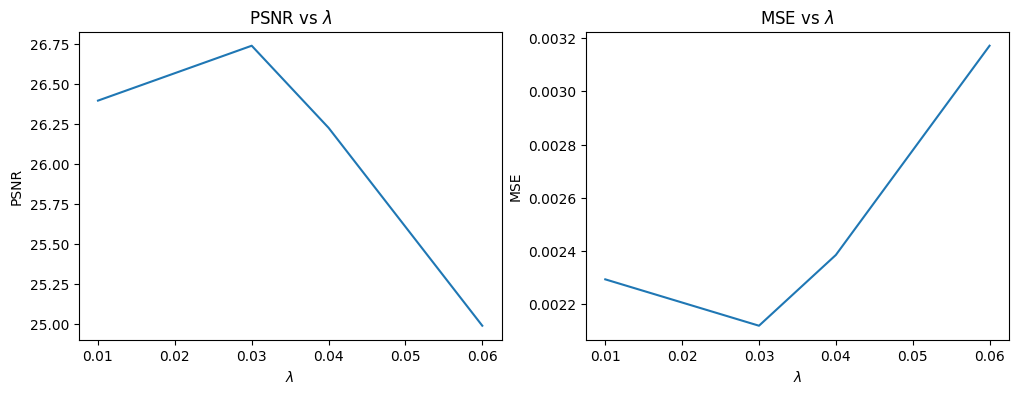

In [18]:
# visualization of the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(lambdas,PSNRs)
ax1.set_title('PSNR vs $\lambda$')
ax1.set_ylabel("PSNR")
ax1.set_xlabel('$\lambda$')
ax2.plot(lambdas,MSEs)
ax2.set_title('MSE vs $\lambda$')
ax2.set_ylabel("MSE")
ax2.set_xlabel('$\lambda$')
plt.show()

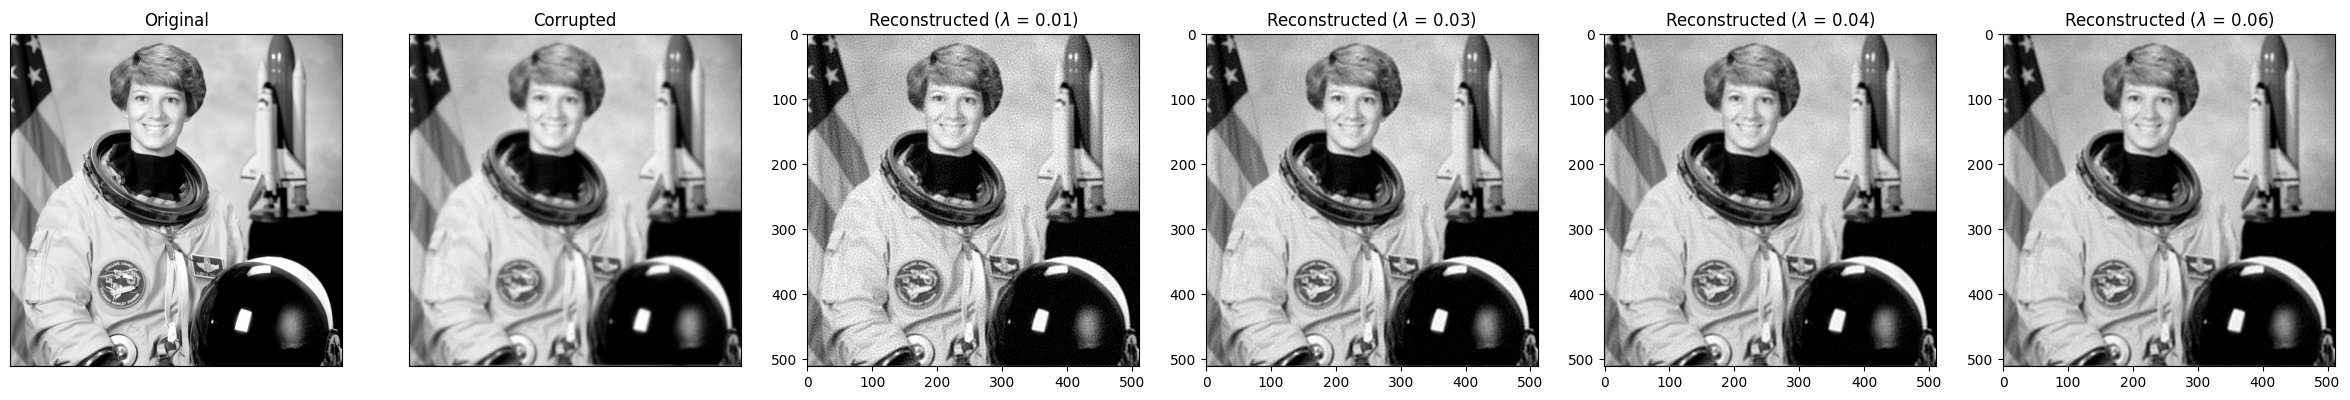

In [19]:
# plot the reconstructed images
plt.figure(figsize=(30, 10))

plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Original")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrupted")
plt.xticks([]), plt.yticks([])


for i, L in enumerate(lambdas):
  plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
  plt.title(f"Reconstructed ($\lambda$ = {L:.2f})")
plt.show()

### Variation of PSNR and MSE with respect to the number of iterations

In [20]:
# fix lambda = 0.3 and analyse the variation of PSNR and MSE with respect to the number of iterations
x0 = y.reshape(m*n)
L = 0.03
iter_range = range(0, 20)

PSNR = np.zeros(len(iter_range))
MSE = np.zeros(len(iter_range))

for k in range(len(iter_range)):
  max_iter = iter_range[k]
  res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})
  X_res = res.x.reshape((m, n))
  PSNR[k] = metrics.peak_signal_noise_ratio(X, X_res)
  MSE[k] = metrics.mean_squared_error(X, X_res)

starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_MSE = np.full(PSNR.shape[0], metrics.mean_squared_error(X, y))

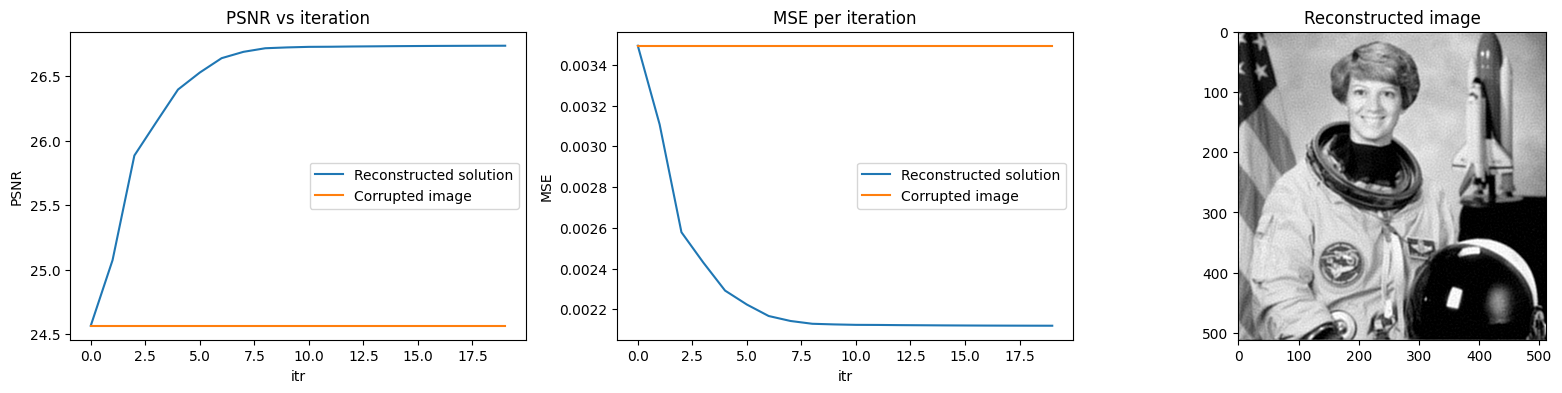

In [21]:
# plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
ax1.plot(iter_range, PSNR, label="Reconstructed solution")
ax1.plot(iter_range, starting_PSNR, label="Corrupted image")
ax1.legend()
ax1.set_title('PSNR vs iteration')
ax1.set_ylabel("PSNR")
ax1.set_xlabel('itr')

ax2.plot(iter_range, MSE, label="Reconstructed solution")
ax2.plot(iter_range, starting_MSE, label="Corrupted image")
ax2.legend()
ax2.set_title('MSE per iteration')
ax2.set_ylabel("MSE")
ax2.set_xlabel('itr')

ax3.imshow(X_res, cmap='gray', vmin=0, vmax=1)
ax3.set_title('Reconstructed image')

plt.show()

### Research of optimal $\lambda$ through experimental tests and according to the discrepancy principle

In [22]:
# research the optimal lambda through experimental tests by starting with a wide
# range of possible values and progressively narrowing it
x0 = y.reshape(m*n)
lambdas = np.linspace(0.01, 0.04, 10)
PSNRs = []
residuals = []

# the code below is the same used for testing various lambdas above
for i, L in enumerate(lambdas):
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter':max_iter})

    X_curr = res.x.reshape(X.shape)

    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    Ax = A(X_curr, K)
    residual = np.linalg.norm((Ax - y).reshape(m*n), ord=2)
    residuals.append(residual)

    print(f'PSNR: {PSNR:.2f}\t Residual: {residual:.4f} \t (\u03BB = {L:.4f})')

PSNR: 26.40	 Residual: 9.9590 	 (λ = 0.0100)
PSNR: 26.78	 Residual: 10.4197 	 (λ = 0.0133)
PSNR: 26.95	 Residual: 10.9551 	 (λ = 0.0167)
PSNR: 26.99	 Residual: 11.5556 	 (λ = 0.0200)
PSNR: 26.96	 Residual: 12.2113 	 (λ = 0.0233)
PSNR: 26.87	 Residual: 12.9129 	 (λ = 0.0267)
PSNR: 26.74	 Residual: 13.6521 	 (λ = 0.0300)
PSNR: 26.58	 Residual: 14.4220 	 (λ = 0.0333)
PSNR: 26.41	 Residual: 15.2169 	 (λ = 0.0367)
PSNR: 26.23	 Residual: 16.0318 	 (λ = 0.0400)


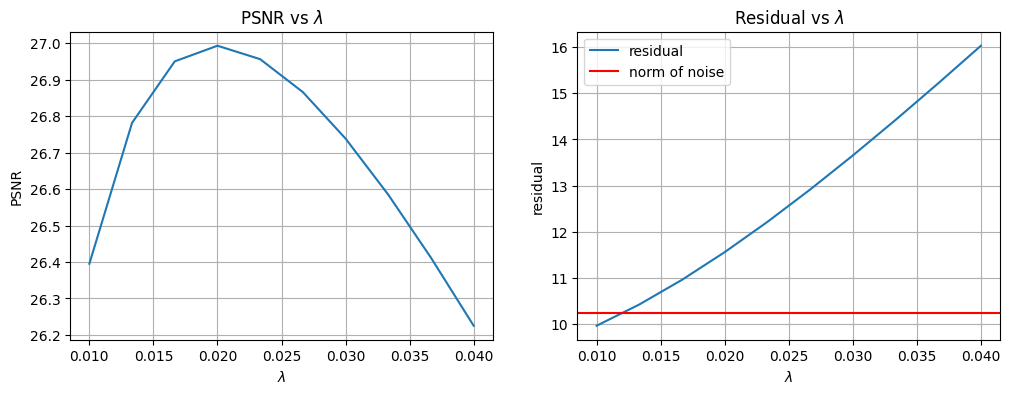

In [23]:
# plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(lambdas,PSNRs)
ax1.set_title('PSNR vs $\lambda$')
ax1.set_ylabel("PSNR")
ax1.set_xlabel('$\lambda$')
ax1.grid()
ax2.plot(lambdas,residuals, label='residual')
ax2.set_title('Residual vs $\lambda$')
ax2.set_ylabel("residual")
ax2.set_xlabel('$\lambda$')

# plot the norm of the noise. According to the discrepancy principle, the optimal
# regularization parameter is the one that results in residual = norm of noise
ax2.axhline(np.linalg.norm(noise.reshape(m*n), ord=2), color='red', label='norm of noise')
ax2.grid()
ax2.legend()
plt.show()

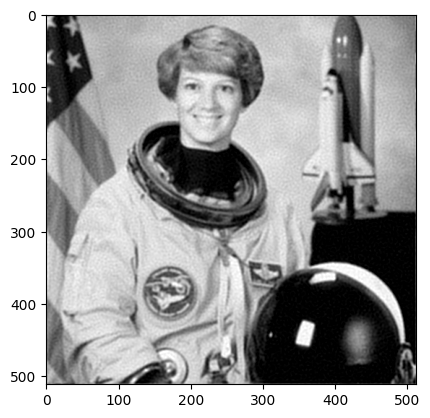

In [24]:
# plot reconstruction for best lambda (0.02)
res = minimize(f, x0, (0.02), method='CG', jac=df, options={'maxiter':max_iter})
X_curr = res.x.reshape(X.shape)

plt.imshow(X_res, cmap='gray', vmin=0, vmax=1)
plt.show()